In [1]:
from os import mkdir
from pathlib import Path

import brightway2 as bw
import bw2calc as bc
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from textwrap import wrap
from project_path import ROOT_DIR

plt.style.use("default")


In [2]:
bw.projects
bw.projects.set_current("GAC_project")
bw.databases

Databases dictionary with 3 object(s):
	GAC_project_db
	biosphere3
	ei39cutoff

In [3]:
ipcc_methods = [
    met
    for met in bw.methods
    if "ipcc 2021" in str(met).lower()
    and "climate change: including SLCFs" in str(met)
    and "no LT" not in str(met)
    and "GWP100" in str(met)
    or ("ipcc 2013" in str(met).lower() and "no LT" not in str(met) and "GWP100" in str(met))
    # or ("ipcc 2021" in str(met).lower() and "no LT" not in str(met) and "GWP100" in str(met))
][1]# [:2]
ipcc_methods


('IPCC 2021',
 'climate change: including SLCFs',
 'global warming potential (GWP100)')

In [4]:
recipe_methods = [
    met
    for met in bw.methods
    if "recipe" in str(met).lower()
    and "2016" in str(met).lower()
    and "endpoint (H)" in str(met)
    and "total" in str(met)
    and "no LT" not in str(met)
    
    # midpoints
    # and "(H)" in str(met)
    # and "endpoint" not in str(met)
]
recipe_methods


[('ReCiPe 2016 v1.03, endpoint (H)',
  'total: ecosystem quality',
  'ecosystem quality'),
 ('ReCiPe 2016 v1.03, endpoint (H)', 'total: human health', 'human health'),
 ('ReCiPe 2016 v1.03, endpoint (H)',
  'total: natural resources',
  'natural resources')]

In [5]:
DB_NAME = "GAC_project_db"

In [6]:
hetero_system = [
    ds
    for ds in bw.Database(DB_NAME)
    if "1-(naphthalen-1-yl)-1H-imidazole" in ds["name"] and "Cu/PCN" in ds["name"]
][0]
hetero_system

'1-(naphthalen-1-yl)-1H-imidazole production with heterogeneous Cu/PCN catalyst (10.8 wt% Cu)' (kilogram, GLO, None)

In [7]:
homoge_system = [
    ds
    for ds in bw.Database(DB_NAME)
    if "1-(naphthalen-1-yl)-1H-imidazole" in ds["name"]
    and "Cu2O/Altman-Buchwald-ligand" in ds["name"]
][0]
homoge_system

'1-(naphthalen-1-yl)-1H-imidazole production with homogeneous Cu2O/Altman-Buchwald-ligand catalytic complex' (kilogram, GLO, None)

In [8]:
bw.calculation_setups

CalculationSetups dictionary with 5 object(s):
	catalysts_only
	contrib
	solveLCA
	solveLCA_scenarios
	trial

In [9]:
def turn_to_scientific(val: float, n_decimals: int, excl_power_range: int = (-1, 1)) -> str:
    """Converts values to scientific notation of the type N x 10^m.

    Parameters
    ----------
    val : float
        Value to (possibly) transform to scientific notation
    n_decimals : int
        Number of decimals of the leading digit
    excl_power_range : tuple of int, default (-1,1)
        (optional) Power range not to be transformed to scientific notation
        By default [-1,1) powers will not be transformed

    Returns
    -------
    sci_val: str
        Value transformed into scientific notation of the type n.nn x 10^m

    Notes
    -----
    Adapted from https://stackoverflow.com/a/31453961/14485040
    """

    left, right = excl_power_range

    s = "{x:.{ndp:d}e}".format(
        x=val, ndp=n_decimals)  # pylint: disable=invalid-name
    digits, power = s.split("e")
    if (
        int(power) not in range(left, right)
    ):  # power is not in provided range -> transform
        sci_val = r"${dig:s}\times 10^{{{pw:d}}}$".format(
            dig=digits, pw=int(power))
    else:  # -> leave unchanged
        sci_val = "{x:.{ndp:d}f}".format(x=val, ndp=n_decimals)

    return sci_val

In [10]:
def do_recursive_calculation(
    activity,
    lcia_method,
    lca_obj=None,
    total_score=None,
    amount=1,
    level=0,
    max_level=3,
    cutoff=1e-2,
):
    """ "Adapted from https://github.com/brightway-lca/brightway2/blob/master/notebooks/Contribution%20analysis%20and%20comparison.ipynb"""

    results = list()

    def get_lca_attributes(activity, lcia_method):
        result_item = dict()
        result_item["database"] = activity["database"]
        result_item["activity name"] = activity["name"]
        result_item["reference product"] = activity["reference product"]
        result_item["unit"] = activity["unit"]
        result_item["location"] = activity["location"]
        result_item[" - ".join(lcia_method) + f' ({bw.Method(lcia_method).metadata["unit"]})'] = lca_obj.score
        return result_item

    if lca_obj is None:
        lca_obj = bc.LCA({activity: amount}, lcia_method)
        lca_obj.lci()
        lca_obj.lcia()
        total_score = lca_obj.score
    elif total_score is None:
        raise ValueError
    else:
        lca_obj.redo_lcia({activity: amount})
        if abs(lca_obj.score) <= abs(total_score * cutoff):
            return

    results.append(get_lca_attributes(activity, lcia_method))

    if level < max_level:
        for exc in activity.technosphere():
            res = (
                do_recursive_calculation(
                    activity=exc.input,
                    lcia_method=lcia_method,
                    lca_obj=lca_obj,
                    total_score=total_score,
                    amount=amount * exc["amount"],
                    level=level + 1,
                    max_level=max_level,
                    cutoff=cutoff,
                )
            )
            results.append(res[0])
            
    return results

In [11]:
res_hetero_gwp = pd.DataFrame(
    do_recursive_calculation(
        activity=hetero_system, lcia_method=ipcc_methods, level=1, max_level=2
    )
)

res_hetero_gwp_plot = res_hetero_gwp.iloc[1:, [2, 5]]
# res_hetero_gwp_plot

res_homoge_gwp = pd.DataFrame(
    do_recursive_calculation(
        activity=homoge_system, lcia_method=ipcc_methods, level=1, max_level=2
    )
)
res_homoge_gwp_plot = res_homoge_gwp.iloc[1:, [2, 5]]
res_homoge_gwp_plot

,reference product,IPCC 2021 - climate change: including SLCFs - global warming potential (GWP100) (kg CO2-Eq)
1,1-iodonaphthalene,2.002083
2,imidazole,2.526824
3,Cu2O/Altman-Buchwald-ligand catalytic complex,54.210020
4,N-methyl-2-pyrrolidone,11.593745


In [12]:
res_homoge_eq = pd.DataFrame(
    do_recursive_calculation(
        activity=homoge_system, lcia_method=recipe_methods[0], level=1, max_level=2
    )
)
res_homoge_eq_plot = res_homoge_eq.iloc[1:, [2, 5]]
res_homoge_eq_plot.iloc[:,1] *= 1e9 # multiply by 1e9
res_homoge_eq_plot

res_hetero_eq = pd.DataFrame(
    do_recursive_calculation(
        activity=hetero_system, lcia_method=recipe_methods[0], level=1, max_level=2
    )
)
res_hetero_eq_plot = res_hetero_eq.iloc[1:, [2, 5]]
res_hetero_eq_plot.iloc[:,1] *= 1e9 # multiply by 1e9
res_hetero_eq_plot

,reference product,"ReCiPe 2016 v1.03, endpoint (H) - total: ecosystem quality - ecosystem quality (species.yr)"
1,1-iodonaphthalene,13.811482
2,imidazole,11.161289
3,Cu/PCN catalyst (10.8 wt% Cu),2.135037
4,dimethyl sulfoxide,1.744744


In [13]:
res_homoge_hh = pd.DataFrame(
    do_recursive_calculation(
        activity=homoge_system, lcia_method=recipe_methods[1], level=1, max_level=2
    )
)
res_homoge_hh_plot = res_homoge_hh.iloc[1:, [2, 5]]
res_homoge_hh_plot.iloc[:,1] *= 1e6 # multiply by 1e6
res_homoge_hh_plot

res_hetero_hh = pd.DataFrame(
    do_recursive_calculation(
        activity=hetero_system, lcia_method=recipe_methods[1], level=1, max_level=2
    )
)
# res_hetero
res_hetero_hh_plot = res_hetero_hh.iloc[1:, [2, 5]]
res_hetero_hh_plot.iloc[:,1] *= 1e6 # multiply by 1e6
res_hetero_hh_plot

,reference product,"ReCiPe 2016 v1.03, endpoint (H) - total: human health - human health (DALYs)"
1,1-iodonaphthalene,9.280134
2,imidazole,5.577956
3,Cu/PCN catalyst (10.8 wt% Cu),1.624831
4,dimethyl sulfoxide,1.038294


In [14]:
res_homoge_nr = pd.DataFrame(
    do_recursive_calculation(
        activity=homoge_system, lcia_method=recipe_methods[2], level=1, max_level=2
    )
)
res_homoge_nr_plot = res_homoge_nr.iloc[1:, [2, 5]]
res_homoge_nr_plot.iloc[:,1] *= 1e1 # multiply by 1e1
res_homoge_nr_plot

res_hetero_nr = pd.DataFrame(
    do_recursive_calculation(
        activity=hetero_system, lcia_method=recipe_methods[2], level=1, max_level=2
    )
)
# res_hetero
res_hetero_nr_plot = res_hetero_nr.iloc[1:, [2, 5]]
res_hetero_nr_plot.iloc[:,1] *= 1e1 # multiply by 1e1
res_hetero_nr_plot

,reference product,"ReCiPe 2016 v1.03, endpoint (H) - total: natural resources - natural resources (USD 2013)"
1,1-iodonaphthalene,1.762329
2,imidazole,3.773720
3,Cu/PCN catalyst (10.8 wt% Cu),0.202768
4,dimethyl sulfoxide,0.669991


In [15]:
pngFilesDir = Path(ROOT_DIR, r"data/interim/png_files") # full path to folder w/png files
svgFilesDir = Path(ROOT_DIR, r"data/interim/svg_files") # full path to folder w/svg files

# Generate required folders if needed
if not Path.exists(pngFilesDir):
    mkdir(pngFilesDir)
if not Path.exists(svgFilesDir):
    mkdir(svgFilesDir)

Preliminary colors:<br>

<b style="background-color: #ef8a62;">heterogeneous</b><br>  
<b style="background-color: #67a9cf;">homogeneous</b><br>

Sequence hetero:<br>
<b style="background-color: #ea7a52;">...1</b><br>
<b style="background-color: #ea987a;">...2</b><br>
<b style="background-color: #e4b6a6;">...3</b><br>
<b style="background-color: #dec8c0;">...4</b><br>

Sequence homo:<br>
<b style="background-color: #459fcc;">...1</b><br>
<b style="background-color: #7eb1cc;">...2</b><br>
<b style="background-color: #adc4cc;">...3</b><br>
<b style="background-color: #c2cecb;">...4</b><br>

In [16]:
## Doughnut CHART colors

allcolors = {
    "heterogeneous": "#ef8a62",
    "homogeneous": "#67a9cf",
}

hetero_colors = ["#ea7a52", "#ea987a", "#e4b6a6", "#dec8c0"]
homoge_colors = ["#459fcc", "#7eb1cc", "#adc4cc", "#c2cecb"]

In [17]:
def plot_doughnut(ax, data, explode, colors, startangle, tot_loc = (0.45, 0.47)):
    
    radius = 0.65
    
    def label_w_value(label, val, allvals):
        pct = np.round(val / np.sum(allvals) * 100, 2)
        absolute = np.round(val, 2)
        return "{:s}\n{:.1f}% ({:.2f})".format(label, pct, absolute)
    
    def value_as_label(val, allvals):
        pct = np.round(val / np.sum(allvals) * 100, 2)
        # absolute = np.round(val, 2)
        absolute = turn_to_scientific(val, 1, (-1,3))
        # return "{:.1f}% ({:.2f})".format(pct, absolute)
        # return "{:.1f}% ({:s})".format(pct, absolute)
        return "{:.1f}%".format(pct)

    # wedges, texts, autotexts = ax.pie(
    wedges, texts = ax.pie(
        data,
        explode=explode,
        colors=colors,
        # autopct=lambda pct: func(pct, data),
        # pctdistance=1.2,
        wedgeprops=dict(width=0.3),
        startangle=startangle,
        radius=radius,
    )

    # bbox_props = dict(boxstyle="round4,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(
        arrowprops=dict(arrowstyle="-"),
        # bbox=bbox_props,
        zorder=0,
        va="center",
        size=6,
    )

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2.0 + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(
            # label_w_value(labels[i], data[i], data),
            value_as_label(data[i], data),
            xy=(x*radius, y*radius),
            xytext=(x * np.sign(x), y),
            horizontalalignment=horizontalalignment,
            **kw
        )

    # total value in the center
    ax.text(
        x=tot_loc[0],
        y=tot_loc[1],
        s=turn_to_scientific(float(np.sum(data)),1,(-1,3)),
        transform=ax.transAxes,
        fontdict=dict(fontsize=7, fontweight="bold"),
    )
    return wedges, texts

In [18]:
labels_hetero_gwp = res_hetero_gwp_plot["reference product"].values.tolist()
data_hetero_gwp = res_hetero_gwp_plot.iloc[:, 1].values.tolist()
explode_hetero_gwp = (0, 0, 0.1, 0)

labels_homoge_gwp = res_homoge_gwp_plot["reference product"].values.tolist()
data_homoge_gwp = res_homoge_gwp_plot.iloc[:, 1].values.tolist()
explode_homoge_gwp = (0, 0, 0.1, 0)

# category_label_gwp = "\n".join(wrap(res_hetero_gwp_plot.columns[1], 36))
category_label_gwp = "Global warming potential\n ($kg_{CO_{2}eq}\ kg^{-1}_{23}$)"

In [19]:
labels_hetero_eq = res_hetero_eq_plot["reference product"].values.tolist()
data_hetero_eq = res_hetero_eq_plot.iloc[:, 1].values.tolist()
explode_hetero_eq = (0, 0, 0.1, 0)

labels_homoge_eq = res_homoge_eq_plot["reference product"].values.tolist()
data_homoge_eq = res_homoge_eq_plot.iloc[:, 1].values.tolist()
explode_homoge_eq = (0, 0, 0.1, 0)

# category_label_eq = "\n".join(wrap(res_hetero_eq_plot.columns[1], 36))
category_label_eq = "Ecosystems quality\n ($10^{-9}\ species·yr\ kg^{-1}_{23}$)"

In [20]:
labels_hetero_hh = res_hetero_hh_plot["reference product"].values.tolist()
data_hetero_hh = res_hetero_hh_plot.iloc[:, 1].values.tolist()
explode_hetero_hh = (0, 0, 0.1, 0)

labels_homoge_hh = res_homoge_hh_plot["reference product"].values.tolist()
data_homoge_hh = res_homoge_hh_plot.iloc[:, 1].values.tolist()
explode_homoge_hh = (0, 0, 0.1, 0)

# category_label_hh = "\n".join(wrap(res_hetero_hh_plot.columns[1], 36))
category_label_hh = "Human health\n ($10^{-6}\ DALYs\ kg^{-1}_{23}$)"

In [21]:
labels_hetero_nr = res_hetero_nr_plot["reference product"].values.tolist()
data_hetero_nr = res_hetero_nr_plot.iloc[:, 1].values.tolist()
explode_hetero_nr = (0, 0, 0.1, 0)

labels_homoge_nr = res_homoge_nr_plot["reference product"].values.tolist()
data_homoge_nr = res_homoge_nr_plot.iloc[:, 1].values.tolist()
explode_homoge_nr = (0, 0, 0.1, 0)

# category_label_nr = "\n".join(wrap(res_hetero_nr_plot.columns[1], 36))
category_label_nr = "Natural resources\n ($10^{-1}\ USD_{2013}\ kg_{23}^{-1}$)"

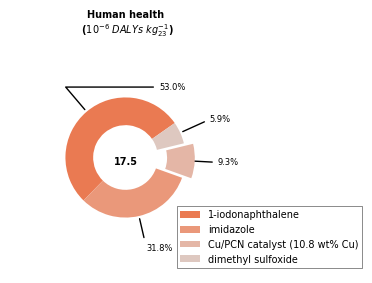

In [22]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

w, t = plot_doughnut(
    ax=ax,
    data=data_hetero_hh,
    explode=explode_hetero_hh,
    colors=hetero_colors,
    startangle=35,
)
    
# legend
leg = ax.legend(w, labels_hetero_hh,
        # title="Inputs:",
        loc="lower left",
        frameon=True,
        fancybox=False,
        edgecolor="k",
        # columnspacing=0.7,
        fontsize=7,
        bbox_to_anchor=(0.7, 0))

leg.get_frame().set_linewidth(0.4)
ax.set_title(
    category_label_hh, fontdict=dict(fontsize=7, fontweight="bold"))

# plt.setp(at, size=7, weight="normal")
plt.show()


NameError: name 'data_homoge' is not defined

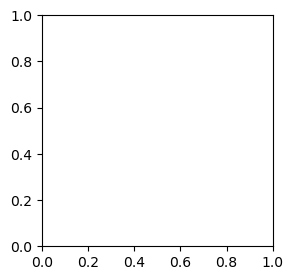

In [23]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

w, t = plot_doughnut(
    ax=ax,
    data=data_homoge,
    explode=explode_homoge,
    colors=homoge_colors,
    startangle=75
)
    
# legend
leg = ax.legend(w, labels_homoge,
        # title="Inputs:",
        loc="lower left",
        frameon=True,
        fancybox=False,
        edgecolor="k",
        # columnspacing=0.7,
        fontsize=7,
        bbox_to_anchor=(0.7, 0))

leg.get_frame().set_linewidth(0.4)
ax.set_title(
    category_label, fontdict=dict(fontsize=7, fontweight="bold"))

# plt.setp(at, size=7, weight="normal")
plt.show()


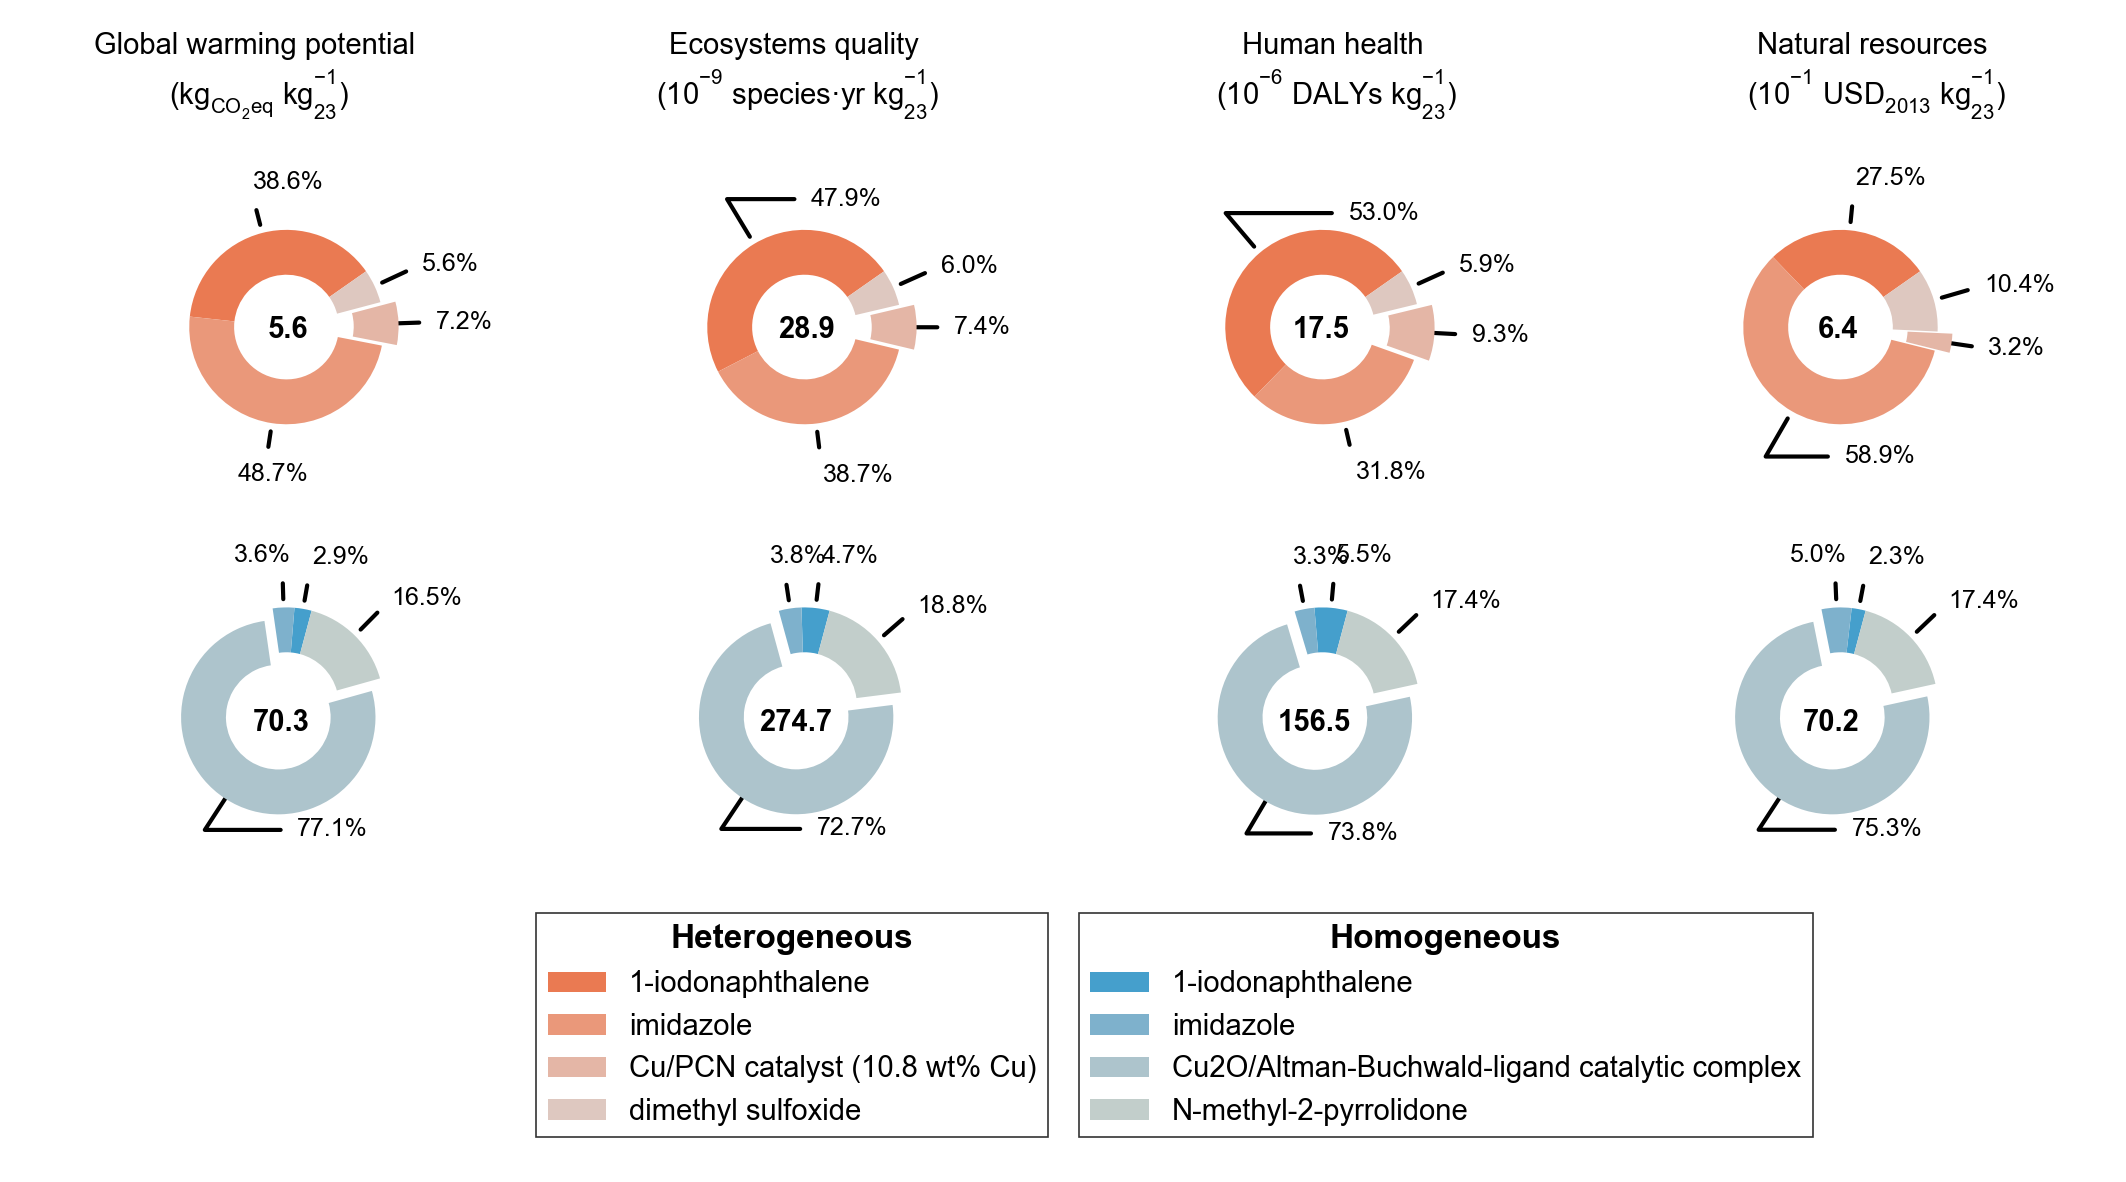

In [24]:
# Plot

# Figure specifications (fonts, sizes, figsize, etc.)
size_legend_font = 8
size_tick_font = 6
size_label_font = 7
mpl.rc("xtick", labelsize=size_tick_font)
mpl.rc("ytick", labelsize=size_tick_font)
mpl.rc("axes", labelsize=size_label_font, linewidth=0.6)
mpl.rc("font", family="Arial")
mpl.rc("mathtext", default="regular")
# mpl.rc('lines', )
# mpl.rc('markers', )
marker_style = dict(lw=0, marker="D", ms=1.5, mec="r", mfc="none", mew=0.7)

# Size of the figure
size_in_mm = (180, 100)  # input the desired size in mm (width, height)

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 2.5  # in mm
from_right = 2.5  # in mm
from_bottom = 2.5  # in mm
from_top = 2.5  # in mm

fig = plt.figure(
    figsize=[x / 25.4 for x in size_in_mm],
    dpi=300,
    #  tight_layout = {'pad': 0}
)

gs = fig.add_gridspec(
    nrows=3,
    ncols=1,
    height_ratios=[0.1, 1, 0.3],
    hspace=0.1,
    top=1 - from_top / size_in_mm[1],
    bottom=from_bottom / size_in_mm[1],
    left=from_left / size_in_mm[0],
    right=1 - from_right / size_in_mm[0],
)

doughnut = gs[1].subgridspec(
    nrows=2,
    ncols=4,
    width_ratios=[1, 1, 1, 1],
    height_ratios=[1, 1],
    wspace=0.01,
    hspace=0.01,
)

category = gs[0].subgridspec(
    nrows=1,
    ncols=4,
    width_ratios=[1, 1, 1, 1],
    wspace=0.2,
)

legend_gs = gs[2].subgridspec(
    nrows=1,
    ncols=2,
    wspace=0.001,
)

ax0 = fig.add_subplot(doughnut[0])
ax1 = fig.add_subplot(doughnut[1])
ax2 = fig.add_subplot(doughnut[2])
ax3 = fig.add_subplot(doughnut[3])
ax4 = fig.add_subplot(doughnut[4])
ax5 = fig.add_subplot(doughnut[5])
ax6 = fig.add_subplot(doughnut[6])
ax7 = fig.add_subplot(doughnut[7])

ax_label0 = fig.add_subplot(category[0])
ax_label0.axis("off")
ax_label1 = fig.add_subplot(category[1])
ax_label1.axis("off")
ax_label2 = fig.add_subplot(category[2])
ax_label2.axis("off")
ax_label3 = fig.add_subplot(category[3])
ax_label3.axis("off")
ax_legend0 = fig.add_subplot(legend_gs[0])
ax_legend0.axis("off")
ax_legend1 = fig.add_subplot(legend_gs[1])
ax_legend1.axis("off")

## DOUGHNUT CHARTS ################################################################
## GWP
w_hetero, t_hetero = plot_doughnut(
    ax=ax0,
    data=data_hetero_gwp,
    explode=explode_hetero_gwp,
    colors=hetero_colors,
    startangle=35,
    tot_loc = (0.45, 0.47)
)
w_homoge, t_homoge = plot_doughnut(
    ax=ax4,
    data=data_homoge_gwp,
    explode=explode_homoge_gwp,
    colors=homoge_colors,
    startangle=75,
    tot_loc = (0.41, 0.43)
)

ax_label0.text(
    x=0.5,
    y=0.0,
    s=category_label_gwp,
    fontdict=dict(fontsize=size_label_font, fontweight="normal"),
    horizontalalignment="center",
)

## EQ
w_hetero, t_hetero = plot_doughnut(
    ax=ax1,
    data=data_hetero_eq,
    explode=explode_hetero_eq,
    colors=hetero_colors,
    startangle=35,
    tot_loc = (0.43, 0.47)
)
w_homoge, t_homoge = plot_doughnut(
    ax=ax5,
    data=data_homoge_eq,
    explode=explode_homoge_eq,
    colors=homoge_colors,
    startangle=75,
    tot_loc = (0.38, 0.43)
)

ax_label1.text(
    x=0.5,
    y=0.0,
    s=category_label_eq,
    fontdict=dict(fontsize=size_label_font, fontweight="normal"),
    horizontalalignment="center",
)

## HH
w_hetero, t_hetero = plot_doughnut(
    ax=ax2,
    data=data_hetero_hh,
    explode=explode_hetero_hh,
    colors=hetero_colors,
    startangle=35,
    tot_loc = (0.42, 0.47)
)
w_homoge, t_homoge = plot_doughnut(
    ax=ax6,
    data=data_homoge_hh,
    explode=explode_homoge_hh,
    colors=homoge_colors,
    startangle=75,
    tot_loc = (0.38, 0.43)
)

ax_label2.text(
    x=0.5,
    y=0.0,
    s=category_label_hh,
    fontdict=dict(fontsize=size_label_font, fontweight="normal"),
    horizontalalignment="center",
)

## NR
w_hetero, t_hetero = plot_doughnut(
    ax=ax3,
    data=data_hetero_nr,
    explode=explode_hetero_nr,
    colors=hetero_colors,
    startangle=35,
    tot_loc = (0.44, 0.47)
)
w_homoge, t_homoge = plot_doughnut(
    ax=ax7,
    data=data_homoge_nr,
    explode=explode_homoge_nr,
    colors=homoge_colors,
    startangle=75,
    tot_loc = (0.40, 0.43)
)

ax_label3.text(
    x=0.5,
    y=0.0,
    s=category_label_nr,
    fontdict=dict(fontsize=size_label_font, fontweight="normal"),
    horizontalalignment="center",
)

## LEGEND ################################################################
leg0 = ax_legend0.legend(w_hetero, labels_hetero_gwp,   
        loc="lower right",
        frameon=True,
        fancybox=False,
        edgecolor="k",
        # columnspacing=0.7,
        fontsize=7,
        title_fontsize=8,
        bbox_to_anchor=(1, 0))
leg0.get_frame().set_linewidth(0.4)
leg0.set_title(title="Heterogeneous", prop={"size":8, "weight":"bold"})

leg1 = ax_legend1.legend(w_homoge, labels_homoge_gwp,
        loc="lower left",
        frameon=True,
        fancybox=False,
        edgecolor="k",
        # columnspacing=0.7,
        fontsize=7,
        title_fontsize=8,
        bbox_to_anchor=(0, 0))
leg1.get_frame().set_linewidth(0.4)
leg1.set_title(title="Homogeneous", prop={"size":8, "weight":"bold"})

## EXPORT ################################################################
# figNamePNG = "LCAscore_total_barplot.png"
figNameSVG = "LCAscore_total_doughnut.svg"

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg


In [ ]:
bw.__version__